In [1]:
import mxnet as mx
from mxnet import nd, autograd as ag
from dataloader import DataLoader
import numpy as np
import datetime
import matplotlib.pylab as plt

# Data

In [2]:
dl = DataLoader('~/.datasets/Han.Xiao/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

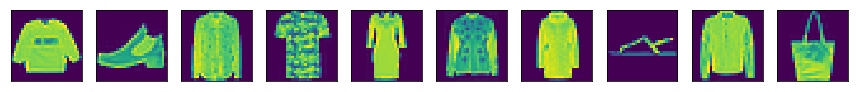

[['pullover'],
 ['ankle boot'],
 ['shirt'],
 ['t-shirt'],
 ['dress,'],
 ['coat'],
 ['coat'],
 ['sandal'],
 ['coat'],
 ['bag']]

In [3]:
DataLoader.show_images(train_img[0:10])
DataLoader.get_labels(train_labels[0:10])

In [4]:
train_img.shape

(60000, 784)

In [5]:
train_labels.shape

(60000,)

In [6]:
# 修改为float以便求导，除以255做归一化
train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

In [7]:
def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j), nd.take(test_lab_nd,j)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j), nd.take(train_lab_nd,j)

# Model

$$\boldsymbol{\hat y} = net({\boldsymbol x}) = softmax({\boldsymbol{x}}\ {W} + {\boldsymbol{b}})$$

In [8]:
md_ctx = mx.gpu()
num_input = 784
num_output = 10
num_examples = len(train_labels)
batch_size = 100

W = nd.random_normal(shape=(num_input, num_output),ctx=md_ctx)
b = nd.random_normal(shape=(num_output),ctx=md_ctx)

params = [W,b]
for p in params:
    p.attach_grad()

In [9]:
def softmax(X):
    e = nd.exp(X)
    t = nd.sum(e, axis=1, keepdims=True)
    return e/t

In [10]:
def net(X):
    X = X.as_in_context(md_ctx)
    return softmax(nd.dot(X,W) + b)

In [11]:
def cross_entropy(yhat,y):
    yhat = yhat.as_in_context(md_ctx)
    y = y.as_in_context(md_ctx)
    return - nd.log(nd.pick(yhat,y))

# Train

In [12]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr*p.grad

In [13]:
# 新建一个“精度”计算的函数
def accuracy(yhat,y):
    yhat = yhat.as_in_context(md_ctx)
    y = y.as_in_context(md_ctx)
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

In [14]:
epochs = 10

t1 = datetime.datetime.now()

for e in range(epochs):
    train_loss = 0.
    train_accu = 0.
    
    for data,label in data_iter(batch_size=batch_size):
        with ag.record():
            yhat = net(data)
            loss = cross_entropy(yhat,label)
        loss.backward()
        SGD(params, 0.1/batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_accu += accuracy(yhat,label)

    print("epoch:%d; loss:%f; accu:%f" % (e, 
                    train_loss/len(train_labels)*batch_size,
                    train_accu/len(train_labels)*batch_size))

print(datetime.datetime.now()-t1)

epoch:0; loss:2.517997; accu:0.568433
epoch:1; loss:1.398741; accu:0.699533
epoch:2; loss:1.170758; accu:0.735667
epoch:3; loss:1.048329; accu:0.754650
epoch:4; loss:0.968290; accu:0.767200
epoch:5; loss:nan; accu:0.532000
epoch:6; loss:nan; accu:0.100000
epoch:7; loss:nan; accu:0.100000
epoch:8; loss:nan; accu:0.100000
epoch:9; loss:nan; accu:0.100000
0:00:07.873552


# Test

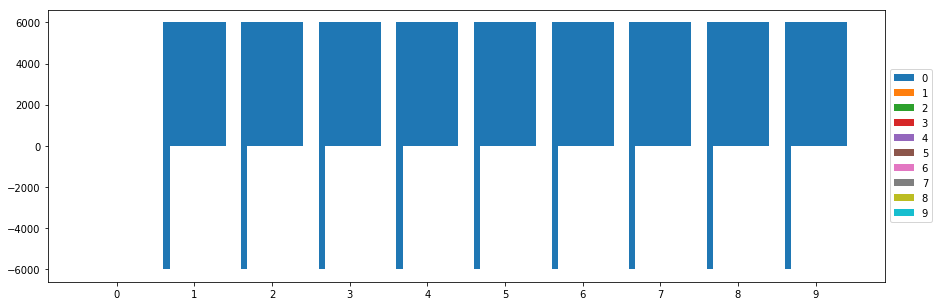

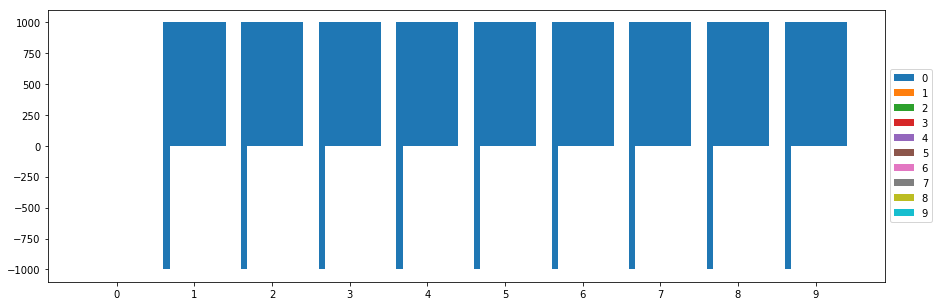

/home/kevin/workspace/kproject/calf/fashion.mnist-multiclasic.regression/statiser.py:31: RuntimeWarning: invalid value encountered in true_divide
  return self.TP/(self.TP+self.FP)


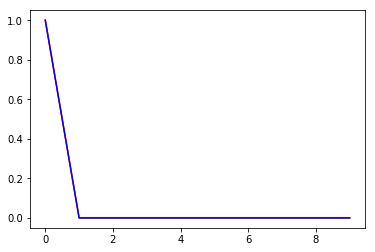

In [15]:
from statiser import Statistics
train_statistics = Statistics(net(train_img_nd).argmax(axis=1).asnumpy(), 
                              train_lab_nd.asnumpy())
test_statistics = Statistics(net(test_img_nd).argmax(axis=1).asnumpy(), 
                             test_lab_nd.asnumpy())
train_statistics.show()
test_statistics.show()
plt.plot(range(10),train_statistics.Recall(),'r')
plt.plot(range(10),train_statistics.Precision(),'g')
plt.plot(range(10),test_statistics.Recall(),'b')
plt.plot(range(10),test_statistics.Precision(),'k')
plt.show()